In [1]:
#Import our necessary python libraries
import pandas as pd
import requests
import json
import os
from collections import defaultdict
from IPython.display import HTML
import plotly.express as px
BLS_API_KEY  = 'd8644c9411c54f5d8333afc4185af8e1'
BLS_ENDPOINT = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

In [2]:
#Grab our data from covidtracking.com through their API.
df_states_current = pd.read_json("https://covidtracking.com/api/states")
df_states_daily   = pd.read_json("https://covidtracking.com/api/us/daily")
df_in_the_press   = pd.read_json("https://covidtracking.com/api/press")
df_us_current     = pd.read_json("https://covidtracking.com/api/us")
df_us_daily       = pd.read_json("https://covidtracking.com/api/us/daily")
df_counties       = pd.read_json("https://covidtracking.com/api/counties")


In [3]:
def get_bls_data(series, start, end):
    headers = {'Content-Type': 'application/json'}
    data = json.dumps({"seriesid": series,'registrationKey': 'd8644c9411c54f5d8333afc4185af8e1', "startyear":"%d" % (start), "endyear":"%d" % (end)})
    p = requests.post(BLS_ENDPOINT, data=data, headers=headers)
    json_data = json.loads(p.text)
    try:
        df = pd.DataFrame()
        for series in json_data['Results']['series']:
            df_initial = pd.DataFrame(series)
            series_col = df_initial['seriesID'][0]
            for i in range(0, len(df_initial) - 1):
                df_row = pd.DataFrame(df_initial['data'][i])
                df_row['seriesID'] = series_col
                if 'code' not in str(df_row['footnotes']): 
                    df_row['footnotes'] = ''
                else:
                    df_row['footnotes'] = str(df_row['footnotes']).split("'code': '",1)[1][:1]
                df = df.append(df_row, ignore_index=True)
        return df
    except:
        json_data['status'] == 'REQUEST_NOT_PROCESSED'
        print('BLS API has given the following Response:', json_data['status'])
        print('Reason:', json_data['message'])


start = 2019
end = 2020

In [4]:

# series = ['LNS14000000', 'LNU05026645', 'LNS12032194', 'LNS14027689']
# unemp = ['LASST340000000000003','LASST340000000000004','LASST340000000000005','LASST340000000000006','LASST340000000000007','LASST340000000000008']
unemp = ['LASST340000000000004']

df_unemployment = get_bls_data(series=unemp, start=start, end=end)
df_unemployment
### Looks like March Data is the most up to date :(

,year,period,periodName,latest,value,footnotes,seriesID
0,2020,M03,March,true,174263,P,LASST340000000000004
1,2020,M02,February,NaN,173873,,LASST340000000000004
2,2020,M01,January,NaN,172261,,LASST340000000000004
3,2019,M12,December,NaN,167704,R,LASST340000000000004
4,2019,M11,November,NaN,168168,R,LASST340000000000004
5,2019,M10,October,NaN,167107,R,LASST340000000000004
6,2019,M09,September,NaN,161982,R,LASST340000000000004
7,2019,M08,August,NaN,155492,R,LASST340000000000004
8,2019,M07,July,NaN,149536,R,LASST340000000000004
9,2019,M06,June,NaN,146273,R,LASST340000000000004


In [5]:
# convert the dateChecked to datetime format for later
df_states_daily['dateChecked'] = df_states_daily['dateChecked'].astype('datetime64[ns]')


In [6]:
# We need to get the earliest date and the latest date so we know how much data to pull
min_date = (df_states_daily.dateChecked.min()).date()
max_date = (df_states_daily.dateChecked.max()).date()

In [7]:
# Create Stock Prices
# We use the min_date and max_date here and save the price history to a df

In [10]:
LH = yf.Ticker("LH")
df_LH = LH.history(
    start=min_date,
    end=max_date)

In [11]:
RHHBY = yf.Ticker("RHHBY")
df_RHHBY = RHHBY.history(
    start=min_date,
    end=max_date)

In [13]:
HOLX = yf.Ticker("HOLX")
df_HOLX = HOLX.history(
    start=min_date,
    end=max_date)

In [14]:
TMO = yf.Ticker("TMO")
df_TMO = TMO.history(
    start=min_date,
    end=max_date)

In [15]:
ABT = yf.Ticker("ABT")
df_ABT = ABT.history(
    start=min_date,
    end=max_date)

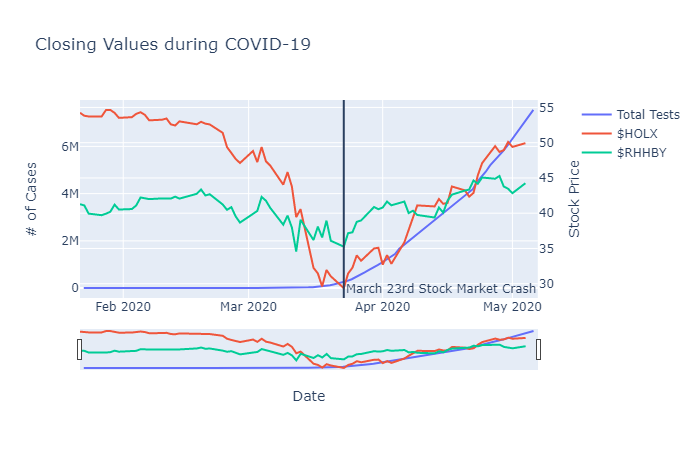

In [22]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# total cases
fig.add_trace(go.Scatter(x=df_states_daily['dateChecked'], y=df_states_daily['totalTestResults'],
                    mode='lines',
                    name='Total Tests'),
             secondary_y=False,)
# HOLX price 
fig.add_trace(go.Scatter(x=df_HOLX.index, y=df_HOLX['Close'],
                    mode='lines',
                    name='$HOLX'),
             secondary_y=True,)


# RHHBY Price
fig.add_trace(go.Scatter(x=df_RHHBY.index, y=df_RHHBY['Close'],
                    mode='lines',
                    name='$RHHBY'),
             secondary_y=True,)
# # TMO Price
# fig.add_trace(go.Scatter(x=df_TMO.index, y=df_TMO['Close'],
#                     mode='lines',
#                     name='$TMO'),
#              secondary_y=True,)
# # LH Price 
# fig.add_trace(go.Scatter(x=df_LH.index, y=df_LH['Close'],
#                     mode='lines',
#                     name='$LH'),
#              secondary_y=True,)
# ABT Price 
# fig.add_trace(go.Scatter(x=df_ABT.index, y=df_ABT['Close'],
#                     mode='lines',
#                     name='$ABT'),
#              secondary_y=True,)

# create market crash line 
fig.update_layout(
    title_text="Closing Values during COVID-19",
    showlegend=True,
    shapes = [dict(
        x0='2020-03-23', x1='2020-03-23', y0=0, y1=1, xref='x', yref='paper',
        line_width=2)],
    annotations=[dict(
        x='2020-03-23', y=0.05, xref='x', yref='paper',
        showarrow=False, arrowhead=7, xanchor='left',yanchor="middle", text='March 23rd Stock Market Crash')]
)
# update labels 
fig.update_xaxes(title_text="Date", rangeslider_visible=True)
fig.update_yaxes(title_text="# of Cases", secondary_y=False)
fig.update_yaxes(title_text="Stock Price", secondary_y=True)



fig.show(renderer="png")

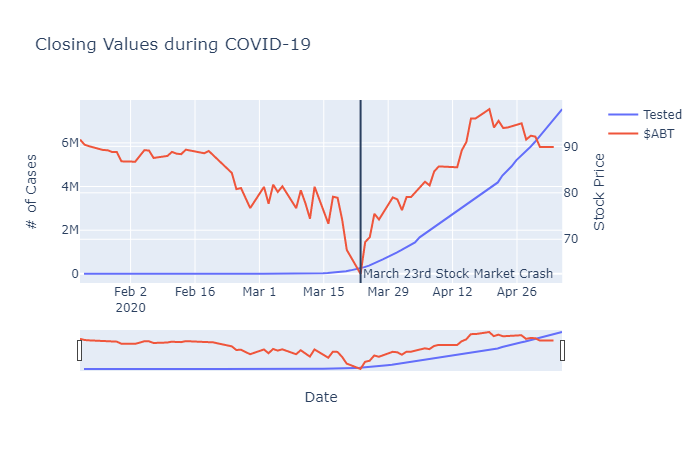

In [23]:
figabt = make_subplots(specs=[[{"secondary_y": True}]])

# Total tested cases
figabt.add_trace(go.Scatter(x=df_states_daily['dateChecked'], y=df_states_daily['totalTestResults'],
                    mode='lines',
                    name='Tested'),
             secondary_y=False,)

# figabt.add_trace(go.Scatter(x=df_TMO.index, y=df_TMO['Close'],
#                     mode='lines',
#                     name='$TMO'),
#              secondary_y=True,)

# figabt.add_trace(go.Scatter(x=df_LH.index, y=df_LH['Close'],
#                     mode='lines',
#                     name='$LH'),
#              secondary_y=True,)
figabt.add_trace(go.Scatter(x=df_ABT.index, y=df_ABT['Close'],
                    mode='lines',
                    name='$ABT'),
             secondary_y=True,)


# create market crash line 
figabt.update_layout(
    title_text="Closing Values during COVID-19",
    showlegend=True,
    shapes = [dict(
        x0='2020-03-23', x1='2020-03-23', y0=0, y1=1, xref='x', yref='paper',
        line_width=2)],
    annotations=[dict(
        x='2020-03-23', y=0.05, xref='x', yref='paper',
        showarrow=False, arrowhead=7, xanchor='left',yanchor="middle", text='March 23rd Stock Market Crash')]
)
# update labels 
figabt.update_xaxes(title_text="Date", rangeslider_visible=True)
figabt.update_yaxes(title_text="# of Cases", secondary_y=False)
figabt.update_yaxes(title_text="Stock Price", secondary_y=True)



figabt.show(renderer="png")

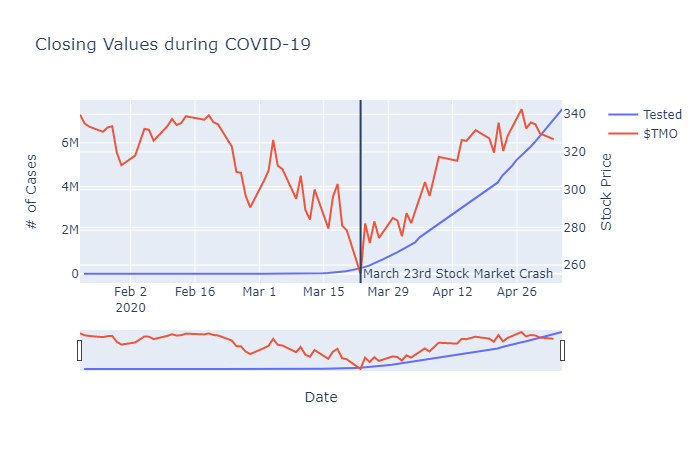

In [24]:
figTMO = make_subplots(specs=[[{"secondary_y": True}]])

# Total tested cases
figTMO.add_trace(go.Scatter(x=df_states_daily['dateChecked'], y=df_states_daily['totalTestResults'],
                    mode='lines',
                    name='Tested'),
             secondary_y=False,)

figTMO.add_trace(go.Scatter(x=df_TMO.index, y=df_TMO['Close'],
                    mode='lines',
                    name='$TMO'),
             secondary_y=True,)

# figTMO.add_trace(go.Scatter(x=df_LH.index, y=df_LH['Close'],
#                     mode='lines',
#                     name='$LH'),
#              secondary_y=True,)


# create market crash line 
figTMO.update_layout(
    title_text="Closing Values during COVID-19",
    showlegend=True,
    shapes = [dict(
        x0='2020-03-23', x1='2020-03-23', y0=0, y1=1, xref='x', yref='paper',
        line_width=2)],
    annotations=[dict(
        x='2020-03-23', y=0.05, xref='x', yref='paper',
        showarrow=False, arrowhead=7, xanchor='left',yanchor="middle", text='March 23rd Stock Market Crash')]
)
# update labels 
figTMO.update_xaxes(title_text="Date", rangeslider_visible=True)
figTMO.update_yaxes(title_text="# of Cases", secondary_y=False)
figTMO.update_yaxes(title_text="Stock Price", secondary_y=True)



figTMO.show(renderer="png")

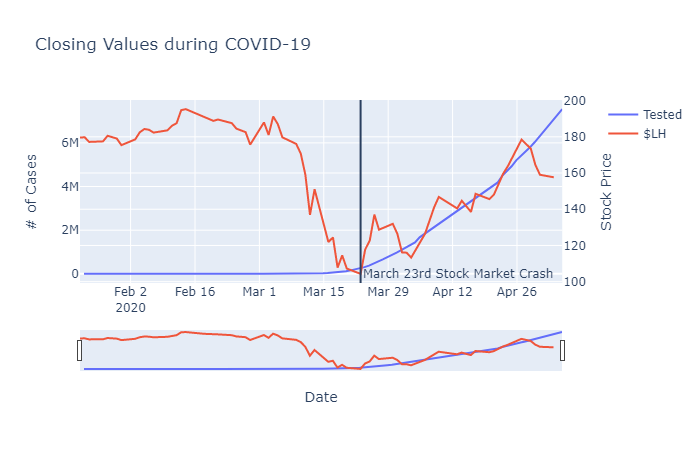

In [25]:
figLH = make_subplots(specs=[[{"secondary_y": True}]])

# Total tested cases
figLH.add_trace(go.Scatter(x=df_states_daily['dateChecked'], y=df_states_daily['totalTestResults'],
                    mode='lines',
                    name='Tested'),
             secondary_y=False,)

figLH.add_trace(go.Scatter(x=df_LH.index, y=df_LH['Close'],
                    mode='lines',
                    name='$LH'),
             secondary_y=True,)


# create market crash line 
figLH.update_layout(
    title_text="Closing Values during COVID-19",
    showlegend=True,
    shapes = [dict(
        x0='2020-03-23', x1='2020-03-23', y0=0, y1=1, xref='x', yref='paper',
        line_width=2)],
    annotations=[dict(
        x='2020-03-23', y=0.05, xref='x', yref='paper',
        showarrow=False, arrowhead=7, xanchor='left',yanchor="middle", text='March 23rd Stock Market Crash')]
)
# update labels 
figLH.update_xaxes(title_text="Date", rangeslider_visible=True)
figLH.update_yaxes(title_text="# of Cases", secondary_y=False)
figLH.update_yaxes(title_text="Stock Price", secondary_y=True)



figLH.show(renderer="png")

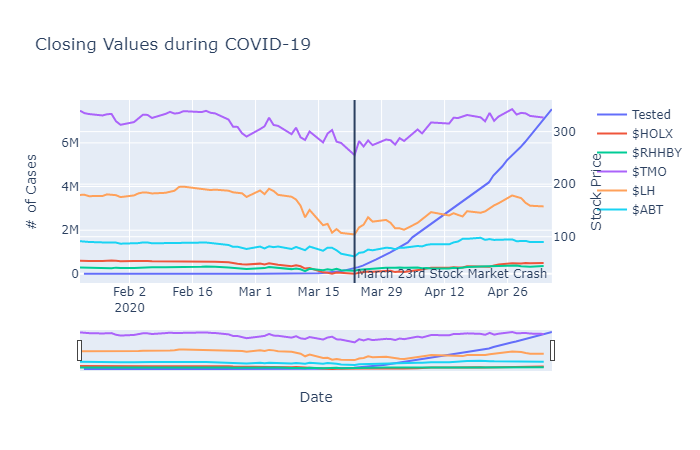

In [26]:
figAll = make_subplots(specs=[[{"secondary_y": True}]])

# Total tested cases
figAll.add_trace(go.Scatter(x=df_states_daily['dateChecked'], y=df_states_daily['totalTestResults'],
                    mode='lines',
                    name='Tested'),
             secondary_y=False,)
# HOLX price 
figAll.add_trace(go.Scatter(x=df_HOLX.index, y=df_HOLX['Close'],
                    mode='lines',
                    name='$HOLX'),
             secondary_y=True,)
# RHHBY Price
figAll.add_trace(go.Scatter(x=df_RHHBY.index, y=df_RHHBY['Close'],
                    mode='lines',
                    name='$RHHBY'),
             secondary_y=True,)
# TMO Price
figAll.add_trace(go.Scatter(x=df_TMO.index, y=df_TMO['Close'],
                    mode='lines',
                    name='$TMO'),
             secondary_y=True,)
# LH Price 
figAll.add_trace(go.Scatter(x=df_LH.index, y=df_LH['Close'],
                    mode='lines',
                    name='$LH'),
             secondary_y=True,)
# ABT Price 
figAll.add_trace(go.Scatter(x=df_ABT.index, y=df_ABT['Close'],
                    mode='lines',
                    name='$ABT'),
             secondary_y=True,)

# create market crash line 
figAll.update_layout(
    title_text="Closing Values during COVID-19",
    showlegend=True,
    shapes = [dict(
        x0='2020-03-23', x1='2020-03-23', y0=0, y1=1, xref='x', yref='paper',
        line_width=2)],
    annotations=[dict(
        x='2020-03-23', y=0.05, xref='x', yref='paper',
        showarrow=False, arrowhead=7, xanchor='left',yanchor="middle", text='March 23rd Stock Market Crash')]
)
# update labels 
figAll.update_xaxes(title_text="Date", rangeslider_visible=True)
figAll.update_yaxes(title_text="# of Cases", secondary_y=False)
figAll.update_yaxes(title_text="Stock Price", secondary_y=True)



figAll.show(renderer="png")